# Exercise 2: Neural Networks

In the previous exercise you implemented a classifier with one linear layer. In this exercise, you will implement a three layer multi-class neural network.

## Submission guidelines:

Your submission should only include this jupyter notebook named ex2_ID.ipynb (not in zip).

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors.
7. **Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. You should include your desired outputs in the output cells to make your code easier to understand.**
8. Write your own code. Cheating will not be tolerated. 
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

**TIP:** You may find the following link helpful: 
http://cs231n.github.io/neural-networks-case-study

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing Helper Code

In [2]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        print("Downloading, This might take several minutes.")
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")
        print("If not, delete the dataset folder and try again.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.
If not, delete the dataset folder and try again.


## Data Preprocessing

**Notice that we are leaving behind the bias trick in this exercise.**

In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data
num_classes = 4

X_train = X_train[np.isin(y_train, range(num_classes))]
y_train = y_train[np.isin(y_train, range(num_classes))]
X_test = X_test[np.isin(y_test, range(num_classes))]
y_test = y_test[np.isin(y_test, range(num_classes))]

# define a splitting for the data
num_training = num_classes*5000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

print(f"Shape of training set: {X_train.shape}")
print(f"Shape of validation set: {X_val.shape}")
print(f"Shape of test set: {X_test.shape}")

classes = ['plane', 'car', 'bird', 'cat']

Shape of training set: (20000, 3072)
Shape of validation set: (1000, 3072)
Shape of test set: (1000, 3072)


     bird      bird     plane     plane


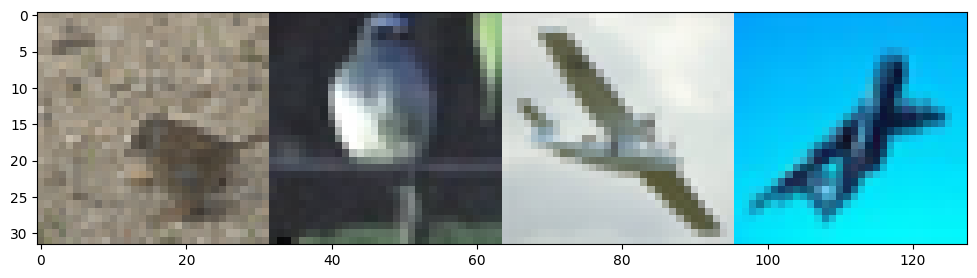

In [5]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print(' '.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x, (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=True));

# Loss

## Cross-entropy


Complete the function `softmax_loss` using vectorized code. This function takes as input `scores`, labels `y` and outputs the calculated loss as a single number and the gradients with respect to X. **(10 Points)**

In [6]:
def softmax_loss(scores, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - scores: scores of shape (N, C) where scores[i, c] is the score for class c on input X[i].
    - y: Vector of labels

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    ###########################################################################
    # TODO: Implement this function                                           #
    ###########################################################################
    N = y.shape[0]

    # Compute the softmax scores
    softmax = np.exp(scores)/np.sum(np.exp(scores), axis=1, keepdims=True)

    # Compute the loss
    loss = -np.sum(np.log(softmax[np.arange(N), y])) / N

    dx = softmax.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return loss, dx

In [7]:
# some tests
np.random.seed(42)

num_instances = 5
num_classes = 3

y = np.random.randint(num_classes, size=num_instances)
scores = np.random.randn(num_instances * num_classes).reshape(num_instances, num_classes)
loss, dx = softmax_loss(scores, y)


correct_grad = np.array([[ 0.0062,  0.1751, -0.1813],
         [-0.1463,  0.0561,  0.0901],
         [ 0.0404,  0.0771, -0.1174],
         [ 0.0223,  0.0855, -0.1078],
         [-0.1935,  0.1358,  0.0578]])
correct_loss = 1.7544
assert np.isclose(dx.round(4), correct_grad, rtol=1e-3).all()
assert np.isclose(loss.round(4), correct_loss, rtol=1e-3).all()

## L2 Regularization

Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights. 
$$
Loss = Loss + \lambda  \cdot \frac{1}{2} \cdot \sum_{i=0}^k w_k^2
$$

Implement the L2 regularization part of the loss in the next cell: **(10 Points)**

In [8]:
def l2_regulariztion_loss(W, reg=0):
    """
    L2 regulariztion loss function, vectorized version.
    - W: a layer's weights.
    - reg: (float) regularization strength
    """
    loss = 0.0
    dW = np.zeros_like(W)
    #############################################################################
    # TODO: Compute the L2 reulariztion loss and its gradient using no 
    # explicit loops.                                                           #
    # Store the loss in loss and the gradient in dW.                            #
    #############################################################################
    
    loss = 0.5*reg*np.sum(W**2)
    dW = W*reg
    
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

# Neural Network

The implementation of linear regression was (hopefully) simple yet not very modular since the layer, loss and gradient were calculated as a single monolithic function. This would become impractical as we move towards bigger models. As a warmup towards `PyTorch`, we want to build networks using a more modular design so that we can implement different layer types in isolation and easily integrate them together into models with different architectures.

This logic of isolation & integration is at the heart of all popular deep learning frameworks, and is based on two methods each layer holds - a forward and backward pass. The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass. The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights. By implementing several types of layers this way, we will be able to easily combine them to build classifiers with different architectures with relative ease.

We will implement a neural network to obtain better results on CIFAR-10. 
Our neural network will be implemented in the following cells. We will train this network using softmax loss and L2 regularization and a ReLU non-linearity.



### Fully Connected Layer: Forward Pass. 

Implement the function `fc_forward`. **(5 Points)**

In [9]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for an fully connected layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - W: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################
    X_reshaped = X.reshape((X.shape[0], -1))
    
    # Compute the forward pass 
    out = X_reshaped.dot(W) + b
        
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (X.copy(), W.copy(), b.copy())
    return out, cache

In [10]:
np.random.seed(42)

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

assert np.isclose(out, correct_out, rtol=1e-8).all()

### Fully Connected Layer: Backward Pass 

Implement the function `fc_backward` **(5 Points)**

In [11]:
def fc_backward(dout, cache):
    """
    Computes the backward pass for an fully connected layer.
    Try the link in the exercise intructions for more details.

    Inputs:
    - dout: Upstream derivatives
    - cache: Tuple of:
      - X: Input data
      - W: Weights
      - b: Biases

    Returns a tuple of:
    - dx: Gradient with respect to X
    - dw: Gradient with respect to W
    - db: Gradient with respect to b
    """
    x, w, b = cache
    dx, dw, db = 0, 0, 0
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################

    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
        
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [12]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [13]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

### ReLU: Forward Pass 

Implement the function `relu_forward`. **(5 Points)**

In [14]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################
    
    out = np.maximum(0, x)
        
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x.copy()
    return out, cache

In [15]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

assert np.isclose(out, correct_out, rtol=1e-8).all() # simple test

### ReLU: Backward Pass

Implement the function `relu_backward`. **(5 Points)**

In [16]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    #############################################################################
    # TODO: Implement the ReLU backward pass.                                   #
    #############################################################################

    dx = dout * (cache > 0)
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx

In [17]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

assert np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test

### Combined Layer
Next combine the fully connected and relu forward\backward functions togther using the functions in the following cell. 
Remember to use functions you already implemented.
**(5 Points)**

In [18]:
def fc_relu_forward(X, W, b):
    """
    Forward pass for a fully connected layer followed by a ReLU.

    Inputs:
    - X: Input to the fc layer
    - W, b: Weights for the fc layer

    Returns:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################
   
    fc_out, fc_cache = fc_forward(X, W, b)
    relu_out, relu_cache = relu_forward(fc_out)
    out = relu_out

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (fc_cache, relu_cache)
    return out, cache


def fc_relu_backward(dout, cache):
    """
    Backward pass for a fully connected layer followed by a ReLU
    Inputs:
    - dout: upstream derivatives
    - cache: parameters calculated during the forward pass

    Returns:
    - dX: derivative w.r.t X
    - dW: derivative w.r.t W
    - db: derivative w.r.t b
    """
    fc_cache, relu_cache = cache
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################
    
    drelu = relu_backward(dout, relu_cache)
    dx, dw, db = fc_backward(drelu, fc_cache)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dw, db

You can check your results in the next cell:

In [19]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dout)

out, cache = fc_relu_forward(x,w,b)
dx, dw, db = fc_relu_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

# Building the Network



Complete the class `ThreeLayerNet`. **(35 Points)**

In [20]:
class ThreeLayerNet(object):
    """
    A three-layer fully-connected neural network. This network has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    In our case, we use the same hidden dimension across all hidden layers.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. In other words, the network has the following architecture:

    input - fc layer - ReLU - fc layer - ReLu - fc layer - softmax

    The outputs of the third fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-2):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, H)
        b2: Second layer biases; has shape (H,)
        W3: Second layer weights; has shape (H, C)
        b3: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in each of the hidden layers.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

    def step(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a three layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization coefficient.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
      
        h1 ,cache1 = fc_relu_forward(X, W1, b1)
        h2, cache2 = fc_relu_forward(h1, W2, b2)
        scores, cache3 = fc_forward(h2, W3, b3)
        # Compute the softmax scores
        #scores = np.exp(h3)/np.sum(np.exp(h3), axis=1, keepdims=True)
                
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        ###############################################################################
        # After you finished the forward pass, compute the loss. This should include  #
        # both the data loss and L2 regularization for W1, W2, W3. Store the result   #
        # in the variable loss, which should be a scalar. Use the softmax_loss        #
        # and l2_regulariztion_loss functions you implemented.                        #         
        ###############################################################################
        loss, dscores = softmax_loss(scores, y)
        reg_loss_1, dw1_reg = l2_regulariztion_loss(W1, reg)
        reg_loss_2, dw2_reg = l2_regulariztion_loss(W2, reg)
        reg_loss_3, dw3_reg = l2_regulariztion_loss(W3, reg)
        
        loss += reg_loss_1 + reg_loss_2 + reg_loss_3
        
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] = dW1 + dW1_reg, it stores the gradient on W1, including      #
        # regularization. It should be a matrix of the same size.                   #
        #############################################################################
        dscores2, dw3, db3 = fc_backward(dscores, cache3)
        dscores1, dw2, db2 = fc_relu_backward(dscores2, cache2)
        dx, dw1, db1 = fc_relu_backward(dscores1, cache1)
        
        grads["W1"] = dw1 + dw1_reg
        grads["W2"] = dw2 + dw2_reg
        grads["W3"] = dw3 + dw3_reg
        grads["b1"] = db1
        grads["b2"] = db2
        grads["b3"] = db3
        
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training label.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None
            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            batch_elements = np.random.choice(num_train, size=batch_size, replace = True)
            X_batch = X[batch_elements]
            y_batch = y[batch_elements]
            
            
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.step(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            self.params['W1'] -= learning_rate*grads["W1"]
            self.params['W2'] -= learning_rate*grads["W2"]
            self.params['W3'] -= learning_rate*grads["W3"]

            self.params['b1'] -= learning_rate*grads["b1"]
            self.params['b2'] -= learning_rate*grads["b2"]
            self.params['b3'] -= learning_rate*grads["b3"]


            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and (it+1) % 100 == 0:
                print ('iteration %d / %d: loss %f' % (it+1, num_iters, loss))

            # Every epoch, check train and val accuracy.
            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this three-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: data points to classify.

        Returns:
        - y_pred: predicted labels
        """
        y_pred = None
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 

        ###########################################################################
        # TODO: Implement this function                                           #
        ###########################################################################

        score_1 = fc_relu_forward(X, W1, b1)[0]
        score_2 = fc_relu_forward(score_1, W2, b2)[0]
        score_3 = fc_forward(score_2, W3, b3)[0]
        y_pred = np.argmax(score_3,axis=1)   
                
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################
        return y_pred

In [21]:
input_size = 32 * 32 * 3
hidden_size = 128
num_classes = 4
model = ThreeLayerNet(input_size, hidden_size, num_classes)

In [22]:
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

iteration 100 / 1500: loss 1.084206
iteration 200 / 1500: loss 1.004476
iteration 300 / 1500: loss 0.900380
iteration 400 / 1500: loss 0.825731
iteration 500 / 1500: loss 0.857723
iteration 600 / 1500: loss 0.719607
iteration 700 / 1500: loss 0.754655
iteration 800 / 1500: loss 0.759193
iteration 900 / 1500: loss 0.672972
iteration 1000 / 1500: loss 0.658957
iteration 1100 / 1500: loss 0.763658
iteration 1200 / 1500: loss 0.724688
iteration 1300 / 1500: loss 0.629747
iteration 1400 / 1500: loss 0.711940
iteration 1500 / 1500: loss 0.669238


In [23]:
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.703


In [24]:
train_acc = (model.predict(X_train) == y_train).mean()
print ('Training accuracy: ', train_acc)

Training accuracy:  0.7445


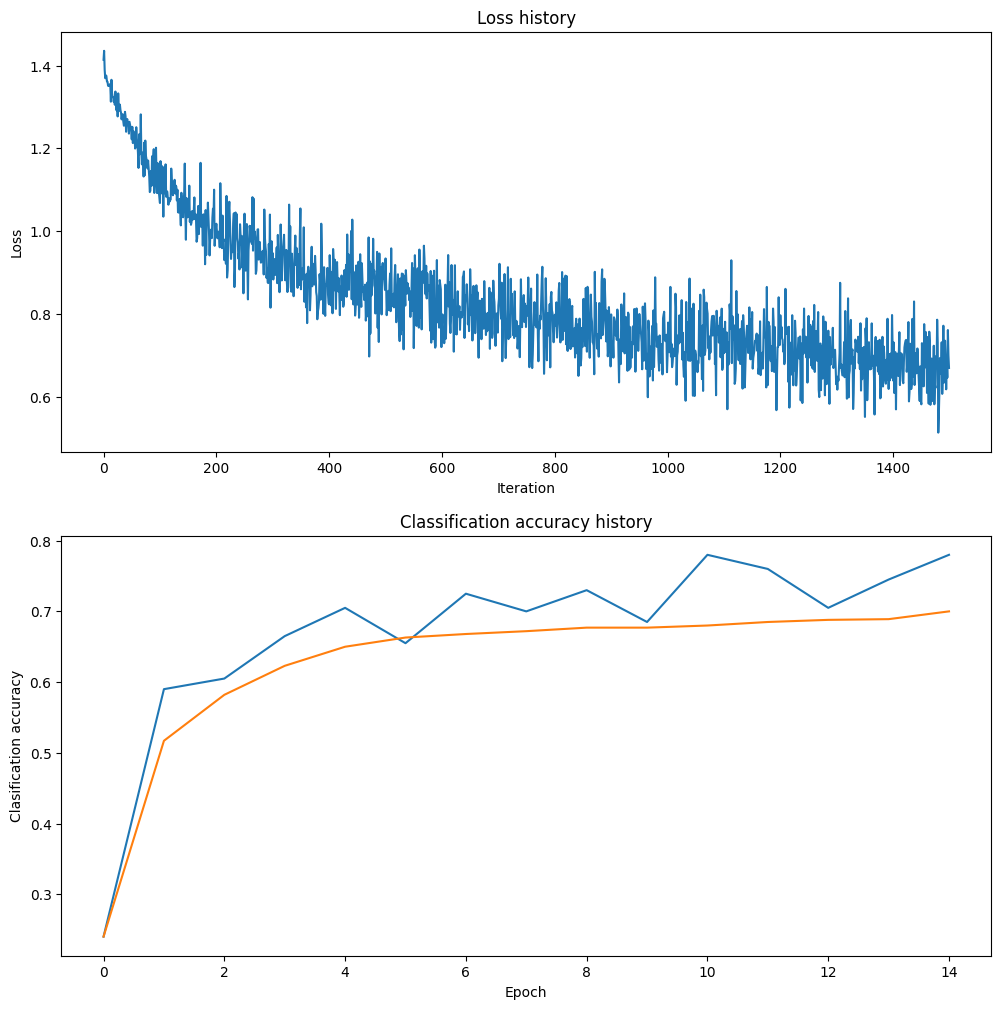

In [25]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

## Hyperparameter Optimization
Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. You should evaluate the best model on the testing dataset and print out the training, validation and testing accuracies for each of the models and provide a clear visualization. Highlight the best model w.r.t the testing accuracy. **(10 Points)**

In [26]:
# This might take some time, try to expirement with small number of testing parameters before continuing
# You are encouraged to experiment with additional values
learning_rates = [1e-4, 1e-3]
hidden_sizes = [32, 64, 128, 256]
regularizations = [0, 0.001, 0.1, 0.25] 

results = {}
best_val = -1   
best_net = None 
################################################################################
#                            START OF YOUR CODE                                #
################################################################################

for lr in learning_rates:
    for hs in hidden_sizes:
        for reg in regularizations:
            model = ThreeLayerNet(input_size, hidden_size, num_classes)
            stats = model.train(X_train, y_train, X_val, y_val, 
                    num_iters=1500, batch_size=200, learning_rate=lr, reg=reg, verbose=True)
val_accuracy = (model.predict(X_val) == y_val).mean()
results[(lr, hidden_size, reg)] = (stats['train_acc_history'][-1], val_accuracy)
if val_accuracy > best_val:
    best_val = val_accuracy
    best_net = model

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, hidden_size, reg  in sorted(results):
    train_accuracy, val_accuracy = results[(lr, hidden_size, reg)]
    print ('lr %e hidden_size %f reg %f train accuracy: %f val accuracy: %f' % (
                lr, hidden_size, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = (best_net.predict(X_test) == y_test).mean()
print ('Neural Network on raw pixels final test set accuracy: %f' % test_accuracy)

iteration 100 / 1500: loss 1.339646
iteration 200 / 1500: loss 1.291167
iteration 300 / 1500: loss 1.292602
iteration 400 / 1500: loss 1.201612
iteration 500 / 1500: loss 1.251922
iteration 600 / 1500: loss 1.202688
iteration 700 / 1500: loss 1.161957
iteration 800 / 1500: loss 1.167116
iteration 900 / 1500: loss 1.162911
iteration 1000 / 1500: loss 1.134660
iteration 1100 / 1500: loss 1.141684
iteration 1200 / 1500: loss 1.212925
iteration 1300 / 1500: loss 1.089073
iteration 1400 / 1500: loss 1.069671
iteration 1500 / 1500: loss 1.025734
iteration 100 / 1500: loss 1.350005
iteration 200 / 1500: loss 1.315630
iteration 300 / 1500: loss 1.290314
iteration 400 / 1500: loss 1.258433
iteration 500 / 1500: loss 1.212005
iteration 600 / 1500: loss 1.243373
iteration 700 / 1500: loss 1.176485
iteration 800 / 1500: loss 1.129191
iteration 900 / 1500: loss 1.149481
iteration 1000 / 1500: loss 1.160293
iteration 1100 / 1500: loss 1.065428
iteration 1200 / 1500: loss 1.074781
iteration 1300 / 15

# Question

##**Question:** 
What can you say about the training? Why does it take much longer to train (compare to hw1)? **(5 Points)**

**Your answer:** In contrast to a simplistic single-layer network (in HW1), the expanded model now comprises multiple layers, each containing a greater number of neurons. Additionally, the introduction of a regularization term aims to enhance the model's robustness. While these enhancements offer increased modeling capacity, they also introduce added complexity to the computations involved.

##**Question:** 

What can you say about the diffrence (or lack of thereof) between the validation and training accuracy? What can you say about the connection between the loss and the accuracy? **(5 Points)**

**Your answer:** Training accuracy is higher than validation accuracy. The results may indicate small overfitting. The model may be too complex, capturing noise in the training data rather than genuine patterns. Therfore,The model may not perform well on new data, as it has memorized training examples rather than learning underlying patterns.
The loss function quantifies the extent of errors in model predictions, providing a continuous measure of performance, while accuracy represents the ratio of correctly predicted instances, offering a binary assessment of overall correctness. 

# The End